<h1>Importing and Configurations/Constants</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.applications.vgg16 import VGG16

from sklearn import preprocessing

import os
import seaborn as sns



In [2]:
train_dir = './Pneumonia_Dataset/chest_xray/train/*'
test_dir = './Pneumonia_Dataset/chest_xray/test/*'
pred_dir =  './Pneumonia_Dataset/chest_xray/val/*'

<h1>DATA PREPARATION</h1>

<h1>Training Images and Label Retrieval</h1>

In [3]:
train_imgs = []
train_lbls = []
for dir_path in glob.glob(train_dir):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path, '*.jpeg')):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_imgs.append(img)
        train_lbls.append(label)


NORMAL
PNEUMONIA


In [4]:
train_imgs = np.array(train_imgs)
train_lbls = np.array(train_lbls)

<h1>Test Images and Label Retrieval</h1>

In [5]:
test_imgs = []
test_lbls = []
for dir_path in glob.glob(test_dir):
    label = dir_path.split("\\")[-1]
    print(label)
    counter = 0
    for img_path in glob.glob(os.path.join(dir_path, '*.jpeg')):
        #print(img_path)
        if counter > 500:
            break
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_imgs.append(img)
        test_lbls.append(label)
        counter += 1

NORMAL
PNEUMONIA


In [6]:
test_imgs = np.array(test_imgs)
test_lbls = np.array(test_lbls)

<h1>Encode labels from text to integers</h1>

In [7]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(test_lbls)
test_e = label_encoder.transform(test_lbls)
label_encoder.fit(train_lbls)
train_e = label_encoder.transform(train_lbls)

In [8]:
x_train, y_train, x_test, y_test = train_imgs, train_e, test_imgs, test_e
x_train = x_train/255.0
x_test = x_test/255.0

In [9]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

<h1> LOADING VGG MODEL FOR FEATURE EXTRACTION</h1>

In [10]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
for layer in vgg.layers:
    layer.trainable = False

In [12]:
feature_extractor = vgg.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [13]:
X_for_RF = features

<h1>FEEDING DATA INTO RANDOM FOREST CLASSIFICATION MODEL</h1>

In [14]:
from sklearn.ensemble import RandomForestClassifier


In [16]:
rf = RandomForestClassifier(n_estimators=200, random_state=10)
rf.fit(X_for_RF, y_train)

RandomForestClassifier(n_estimators=200, random_state=10)

In [17]:
x_test_feature = vgg.predict(x_test)
x_test_features = x_test_feature.reshape(x_test_feature.shape[0], -1)

In [18]:
prediction = rf.predict(x_test_features)
prediction = label_encoder.inverse_transform(prediction)

[[210 128]
 [  7 494]]


<AxesSubplot:>

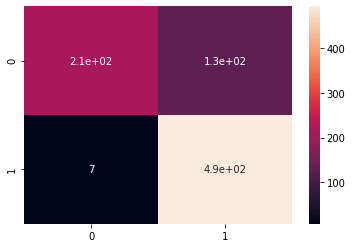

In [19]:
#Confusion Matrix - verify accuracy of each class
from sklearn import metrics

cm = metrics.confusion_matrix(test_lbls, prediction)
print(cm)
sns.heatmap(cm, annot=True)

In [20]:
print('Accuracy: ', metrics.accuracy_score(test_lbls, prediction))

Accuracy:  0.8390941597139452


Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  NORMAL   Incorrect!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['NORMAL']  >>> Actual:  NORMAL   Correct!
Prediction:  ['NORMAL']  >>> Actual:  NORMAL   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['NORMAL']  >>> Actual:  NORMAL   Correct!
Prediction:  ['PNEUMONIA']  >>> Actual:  PNEUMONIA   Correct!
Prediction:  ['NORMAL']  >>> Actual:  NORMAL   Correct!
Prediction:  ['NORMAL']  >>> Actual:  PNEUMONIA   Incorrect!
Prediction:  ['NORMAL']  >>> Actua

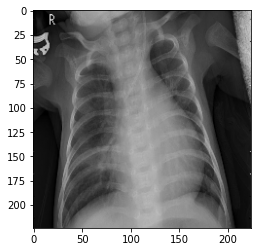

In [31]:
corr_ct = 0
for i in range(20):
    n = np.random.randint(0, x_test.shape[0])
    img = x_test[n]

    plt.imshow(img)
    input_img = np.expand_dims(img, axis=0)
    input_img_feature = vgg.predict(input_img)
    input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)

    prediction = rf.predict(input_img_features)[0]
    prediction = label_encoder.inverse_transform([prediction])
    correct = 'Incorrect!'
    if prediction == test_lbls[n]:
        correct = 'Correct!'
        corr_ct += 1
    print('Prediction: ', prediction, ' >>> Actual: ', test_lbls[n], ' ', correct)
print(corr_ct, ' out of 20 samples guessed right.')